# Imports

In [32]:
import pandas as pd
import os
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Data Preprocessing

### Ouverture du fichier

In [1]:
data = pd.read_table("../../data/welddb.data",sep = " ", header=None)

### Correction des instances corrompues

In [34]:
data.replace('N', None, inplace=True)
data.columns = ["C concentration (weight%)","Si concentration (weight%)", "Mn concentration (weight%)","S concentration (weight%)", "P concentration (weight%)", "Ni concentration (weight%)", "Cr concentration (weight%)", "Mo concentration (weight%)", "V concentration (weight%)", "Cu concentration (weight%)", "Co concentration (weight%)", "W concentration (weight%)", "O concentration (ppm/weight)", "Ti concentration (ppm/weight)", "N concentration (ppm/weight)", "Al concentration (ppm/weight)", "B concentration (ppm/weight)", "Nb concentration (ppm/weight)", "Sn concentration (ppm/weight)", "As concentration (ppm/weight)", "Sb concentration (ppm/weight)", "Current (A)", "Voltage (V)", "AC or DC", "Electrode positive or negative", "Heat input (kJ/mm)", "Interpass temperature (deg C)", "Type of weld", "Post weld heat treatment temperature (deg C)", "Post weld heat treatment time (hours)", "Yield strength (MPa)", "Ultimate tensile strength (MPa)", "Elongation (%)", "Reduction of Area (%)", "Charpy temperature (deg C)", "Charpy impact toughness (J)", "Hardness (kg/mm2)", "50 FATT", "Primary ferrite in microstructure (%)", "Ferrite with second phase (%)", "Acicular ferrite (%)", "Martensite(%)", "Ferrite with carbide aggreagate (%)", "Weld ID"]
data = data.replace("<","",regex=True)
data['N concentration (ppm/weight)'] = data['N concentration (ppm/weight)'].str.split("tot").str[0]
data['Hardness (kg/mm2)'] = data['Hardness (kg/mm2)'].str.split("(").str[0]
data['Hardness (kg/mm2)'] = data['Hardness (kg/mm2)'].str.split("H").str[0]
data['Interpass temperature (deg C)'] = data['Interpass temperature (deg C)'].replace('150-200','175')
for i, column in enumerate(data.columns):
    if i not in [23,24,27,43]:
        data[column] = data[column].astype(float)

data.columns = data.columns.map(str)

# Missing values analysis

<Axes: >

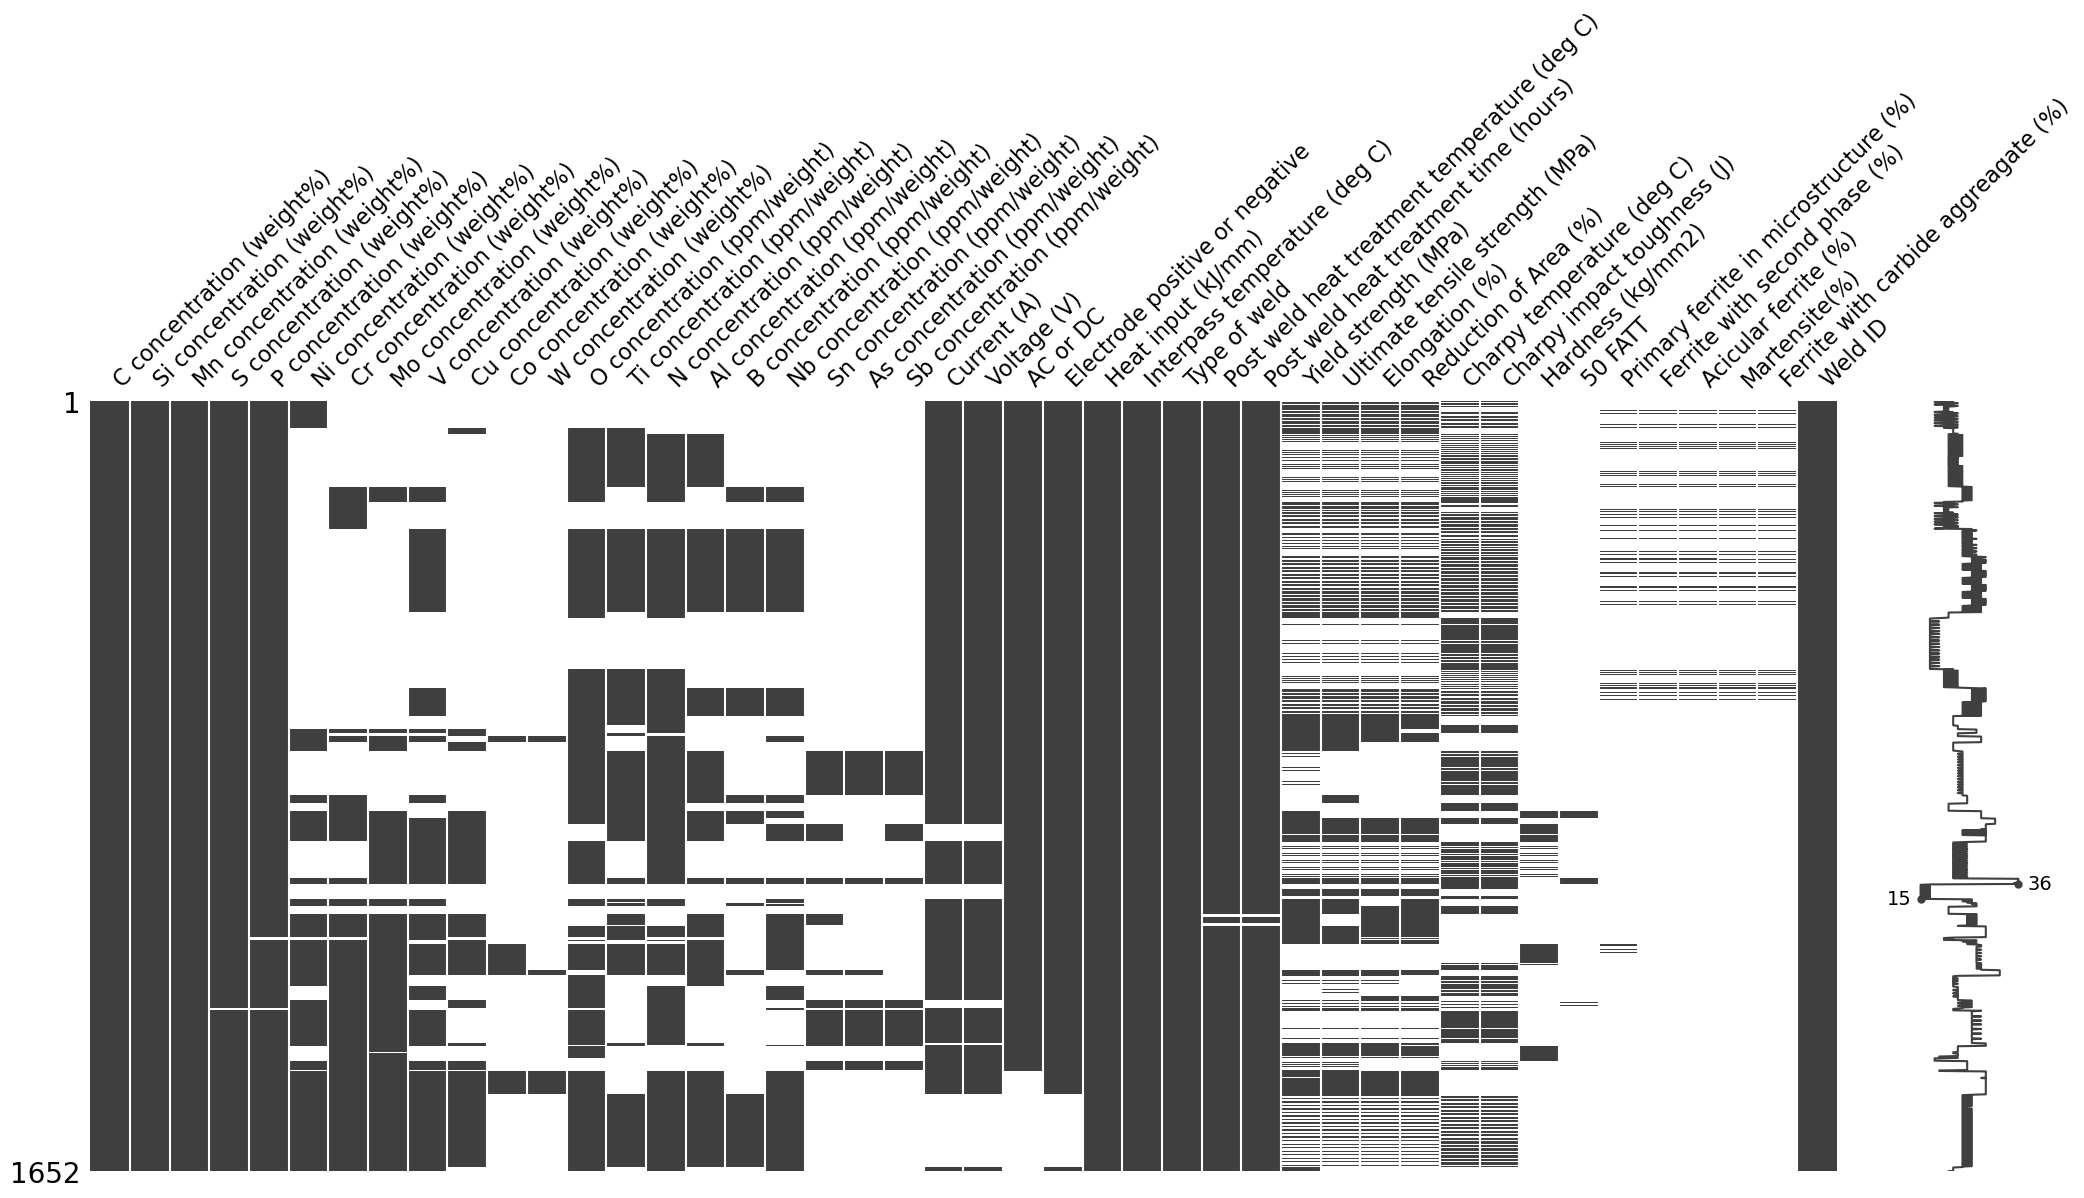

In [6]:
msno.matrix(data)

### Droping useless columns of the end

<Axes: >

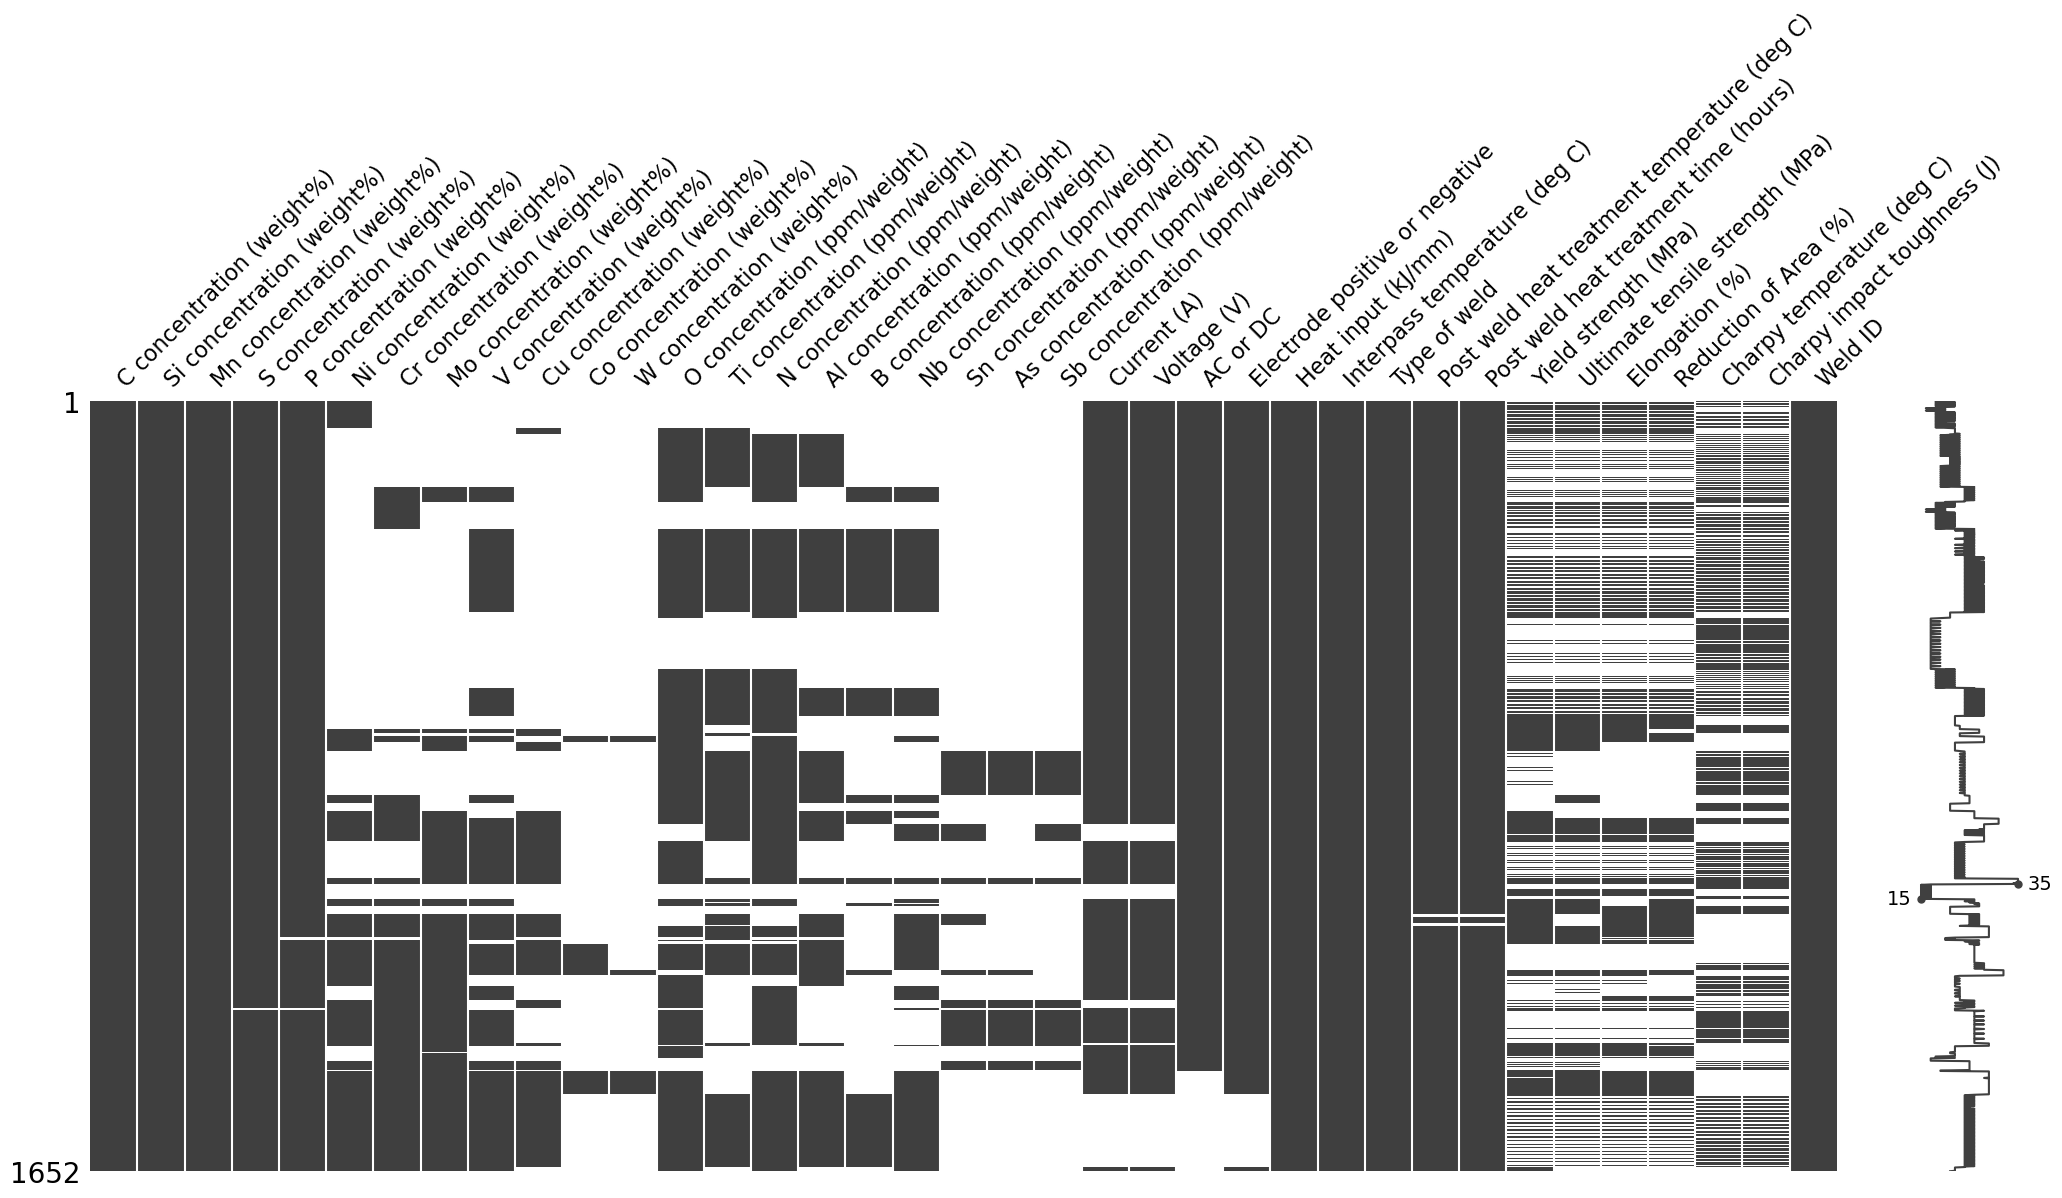

In [35]:
data = data.drop(["Hardness (kg/mm2)", "50 FATT", "Primary ferrite in microstructure (%)", "Ferrite with second phase (%)", "Acicular ferrite (%)", "Martensite(%)", "Ferrite with carbide aggreagate (%)"],axis=1)
msno.matrix(data)

# Boxplot of the different quantitative variables

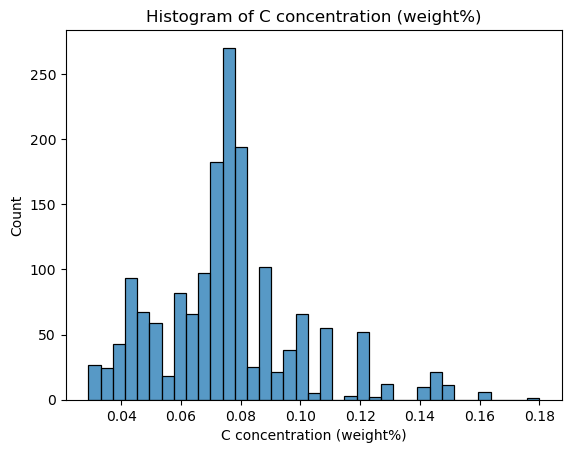

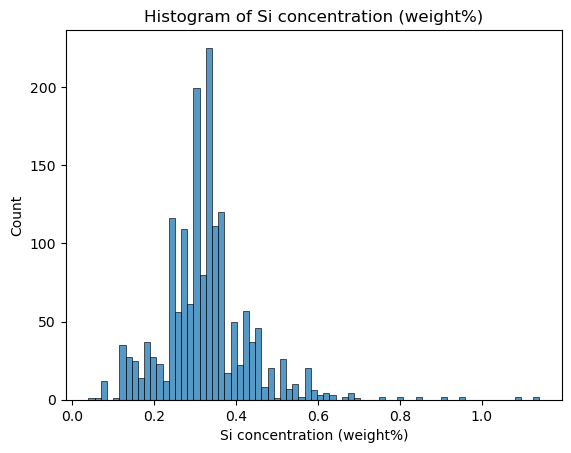

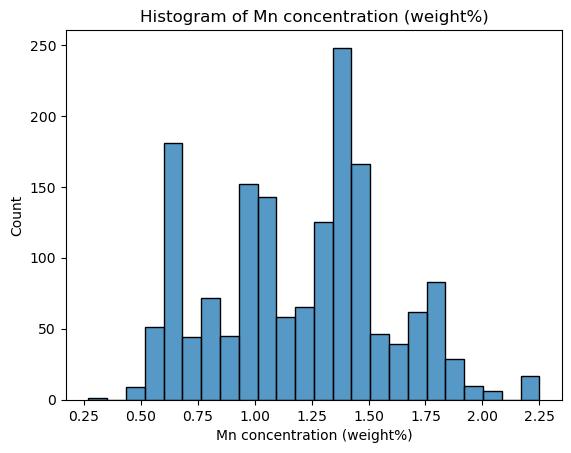

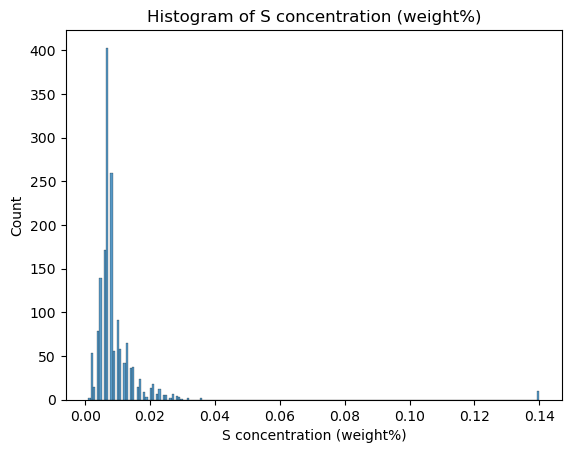

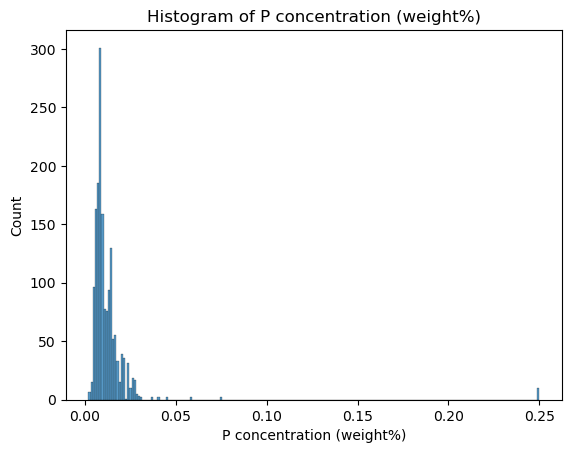

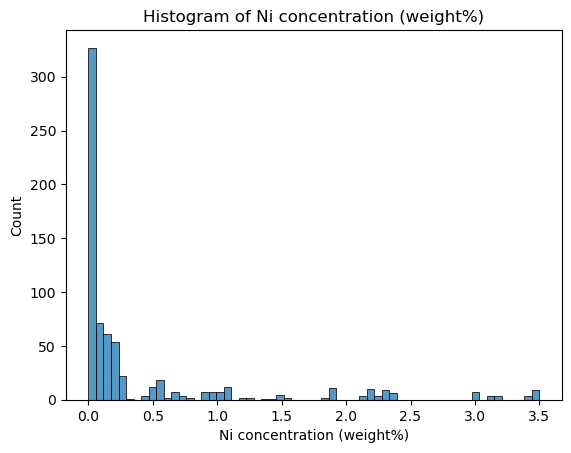

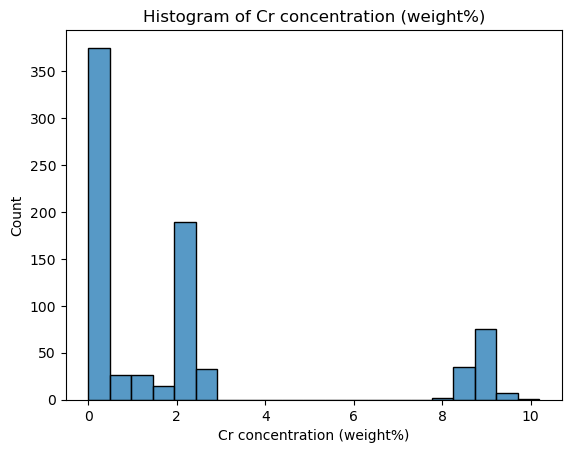

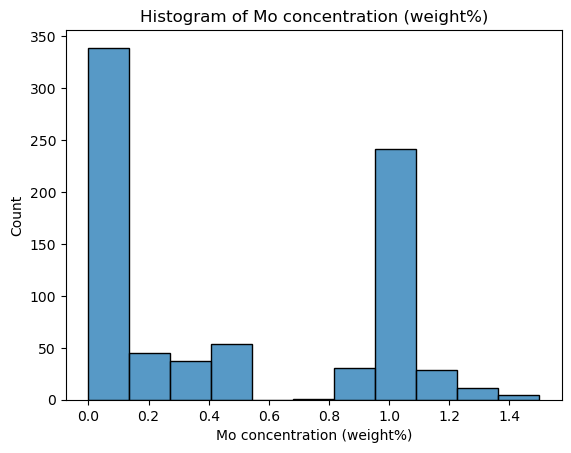

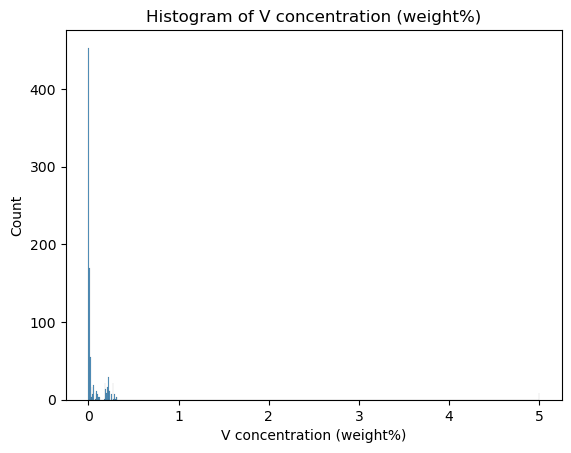

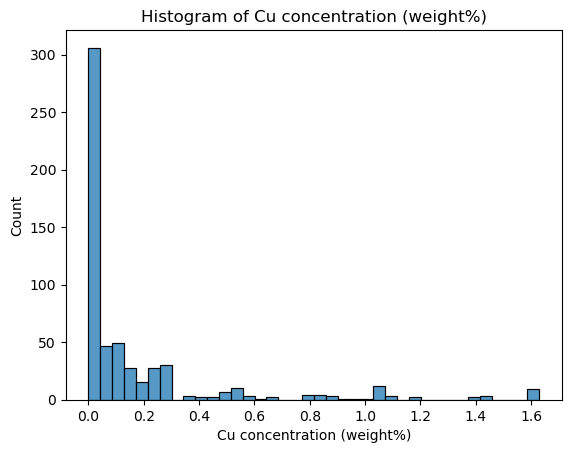

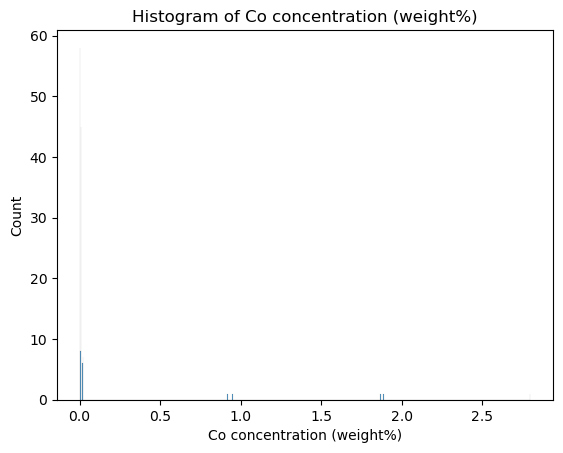

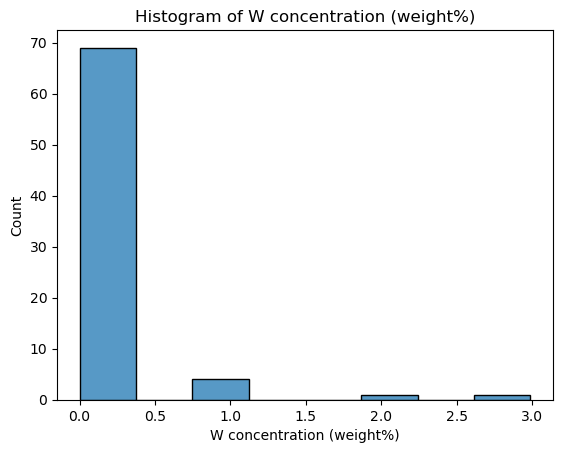

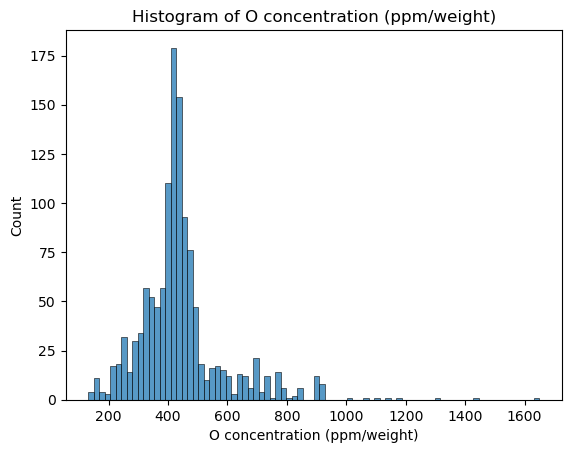

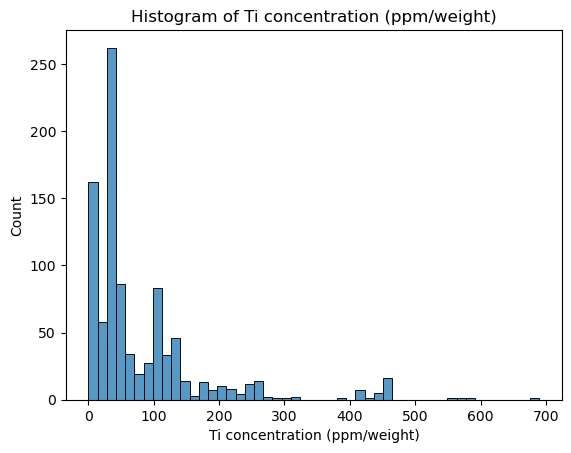

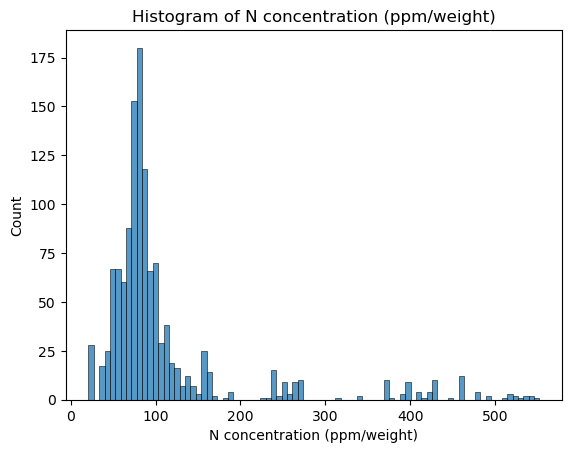

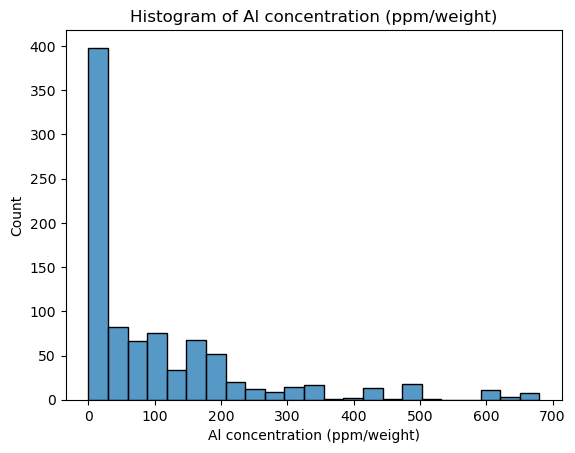

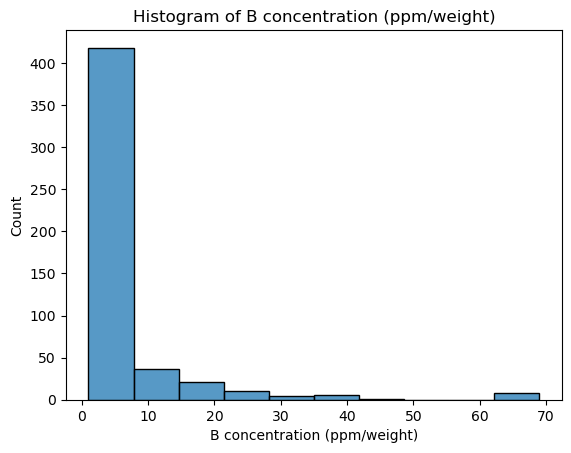

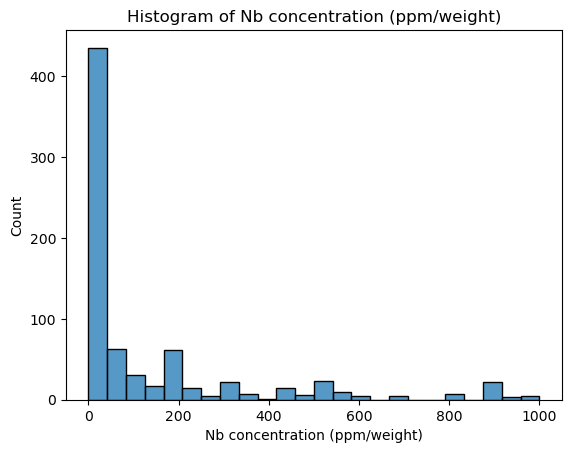

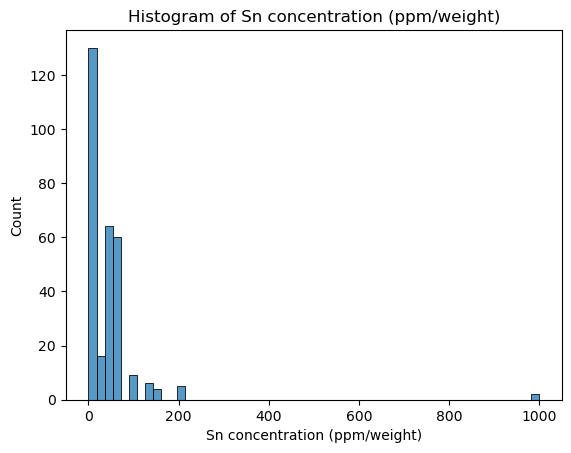

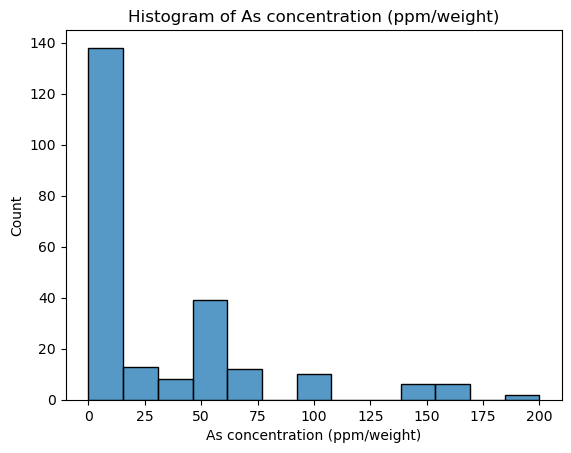

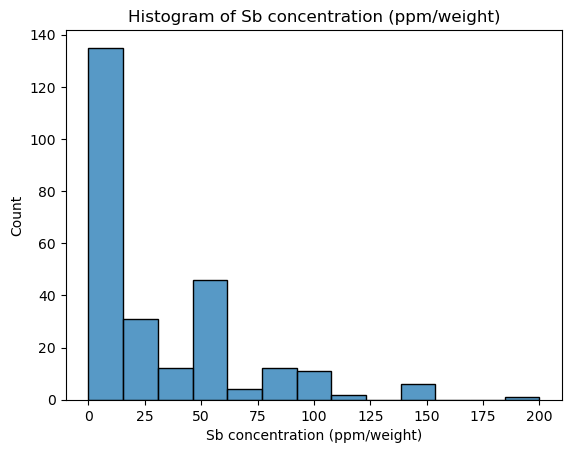

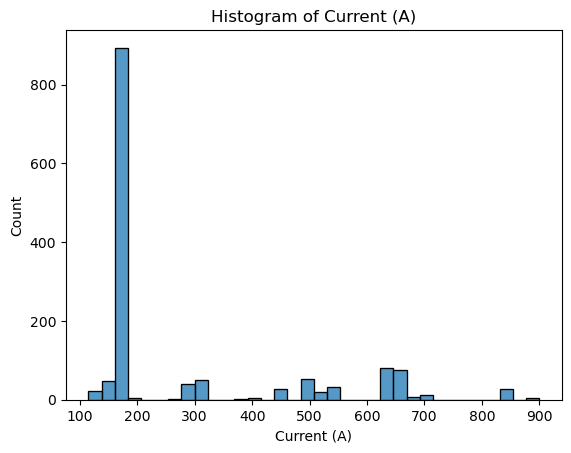

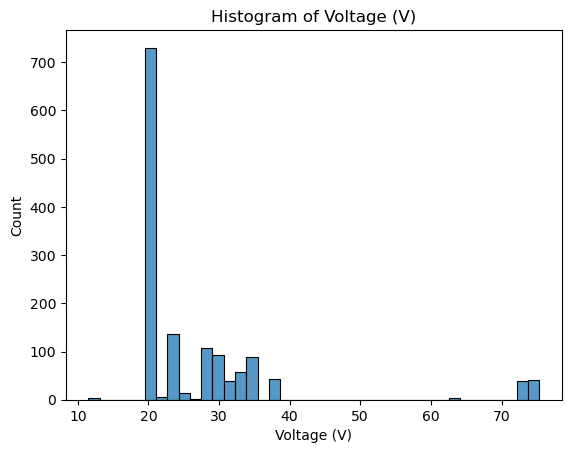

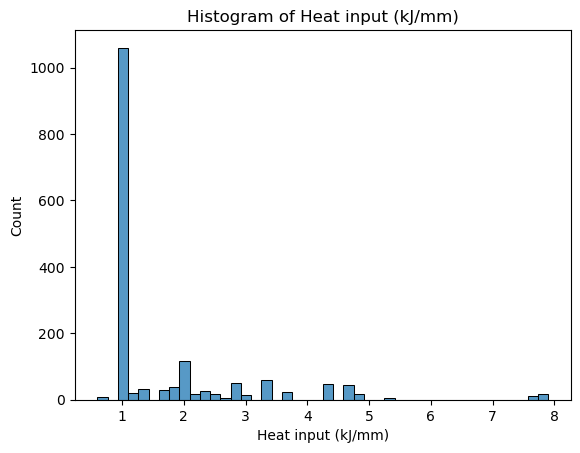

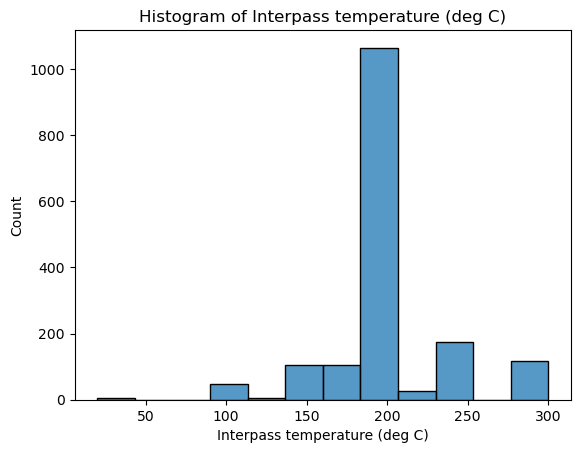

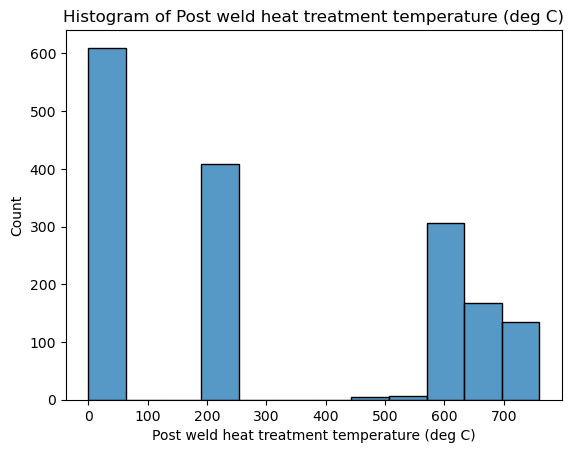

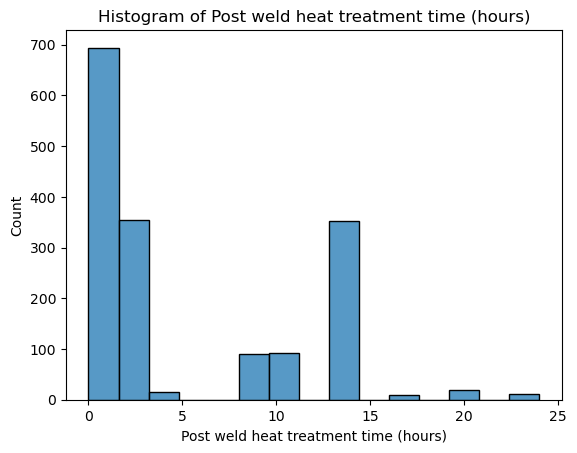

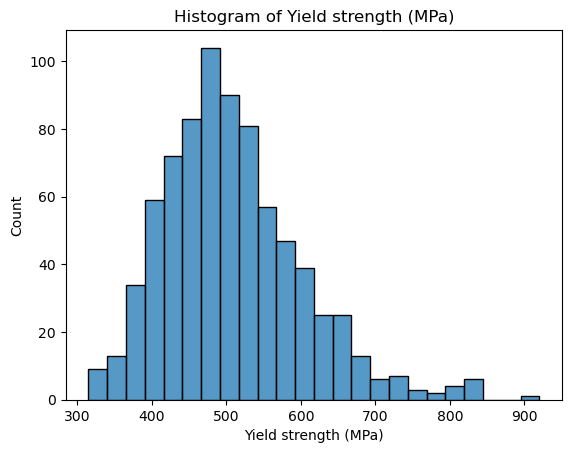

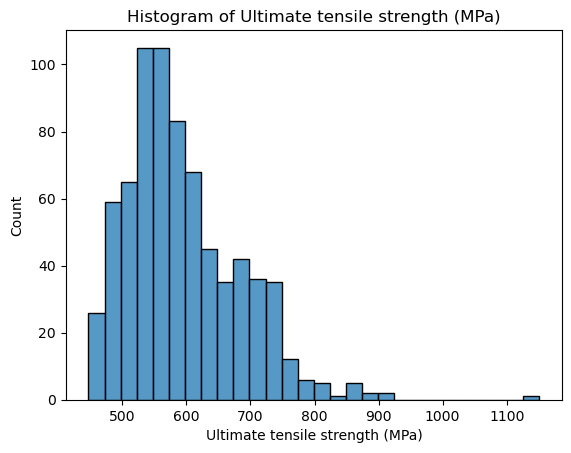

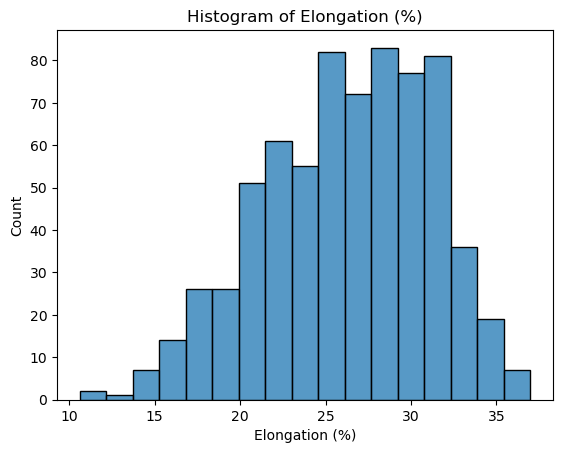

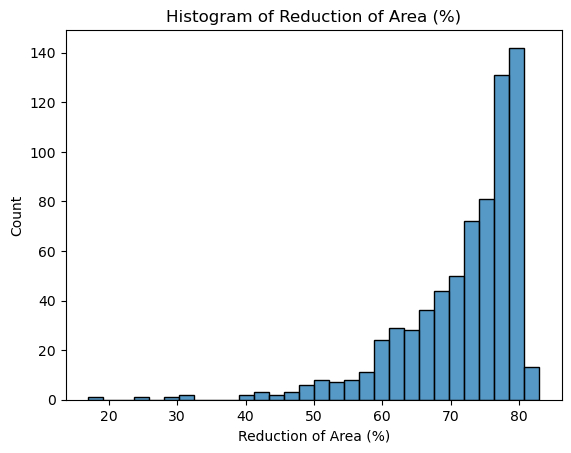

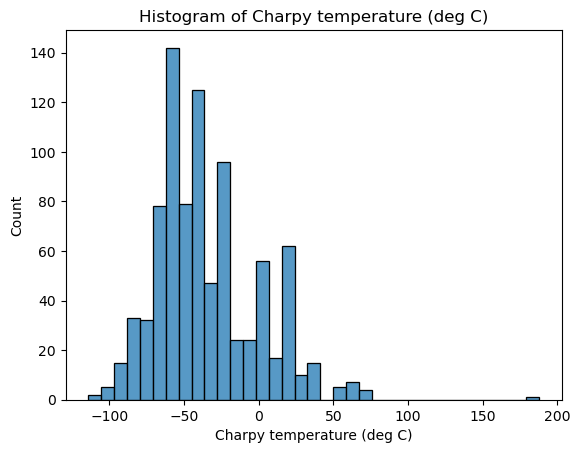

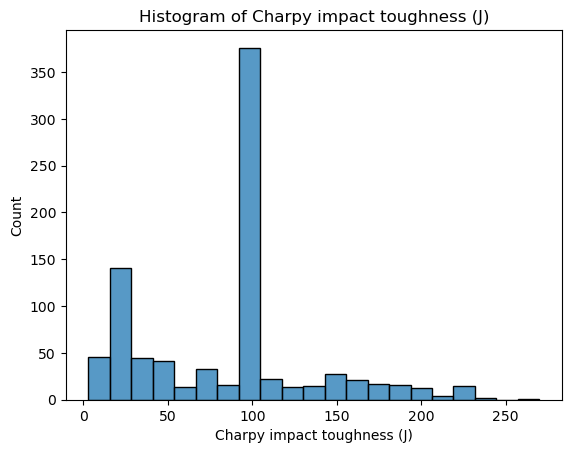

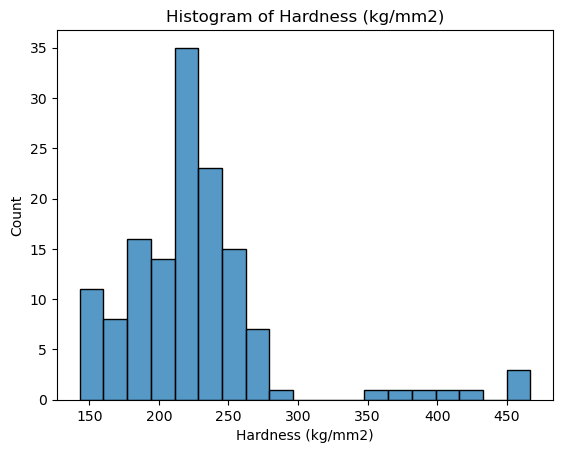

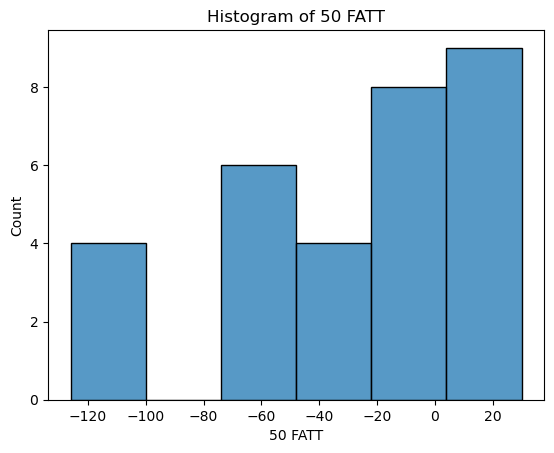

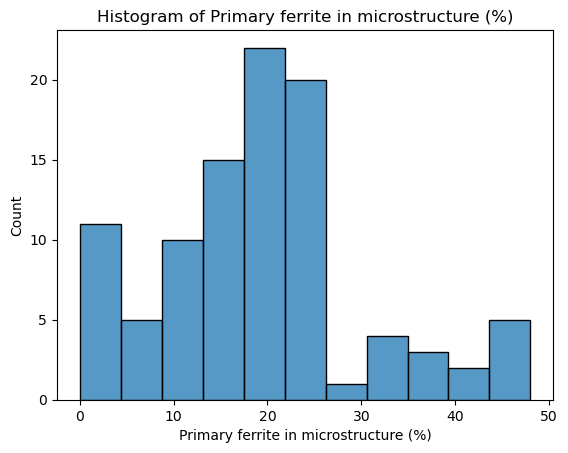

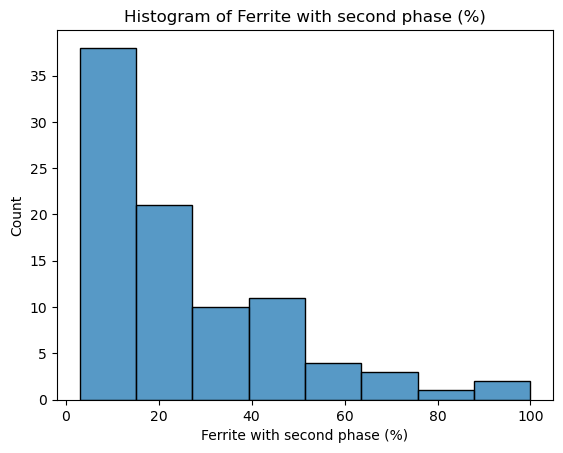

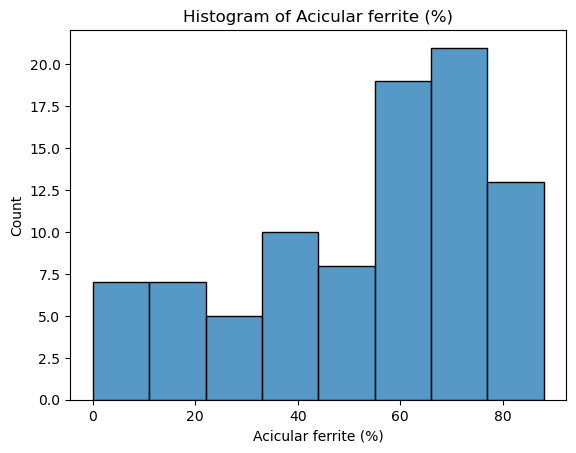

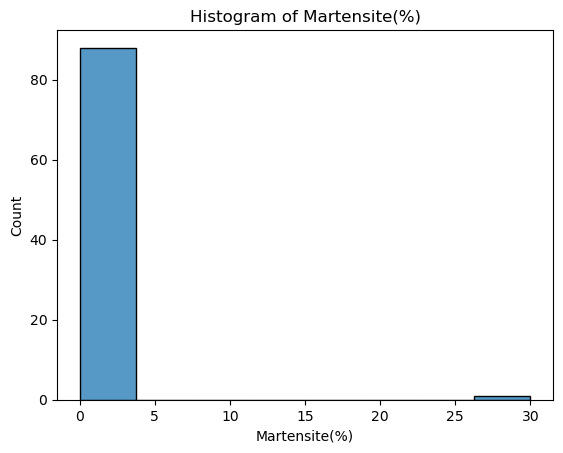

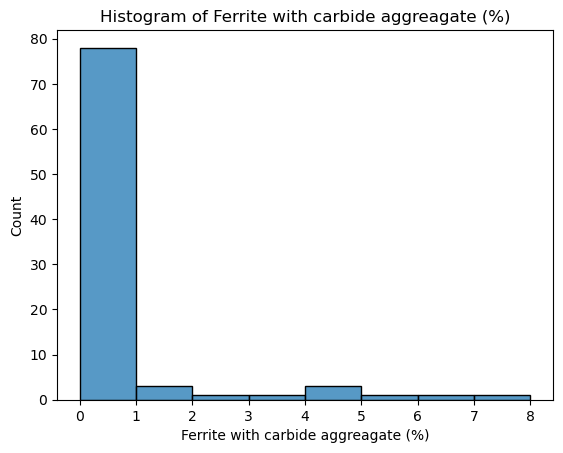

In [5]:
for col in data.select_dtypes(include='number').columns:
    sns.histplot(data[col])
    plt.title(f'Histogram of {col}')
    plt.show()

### Imputing 0 concentrations

<Axes: >

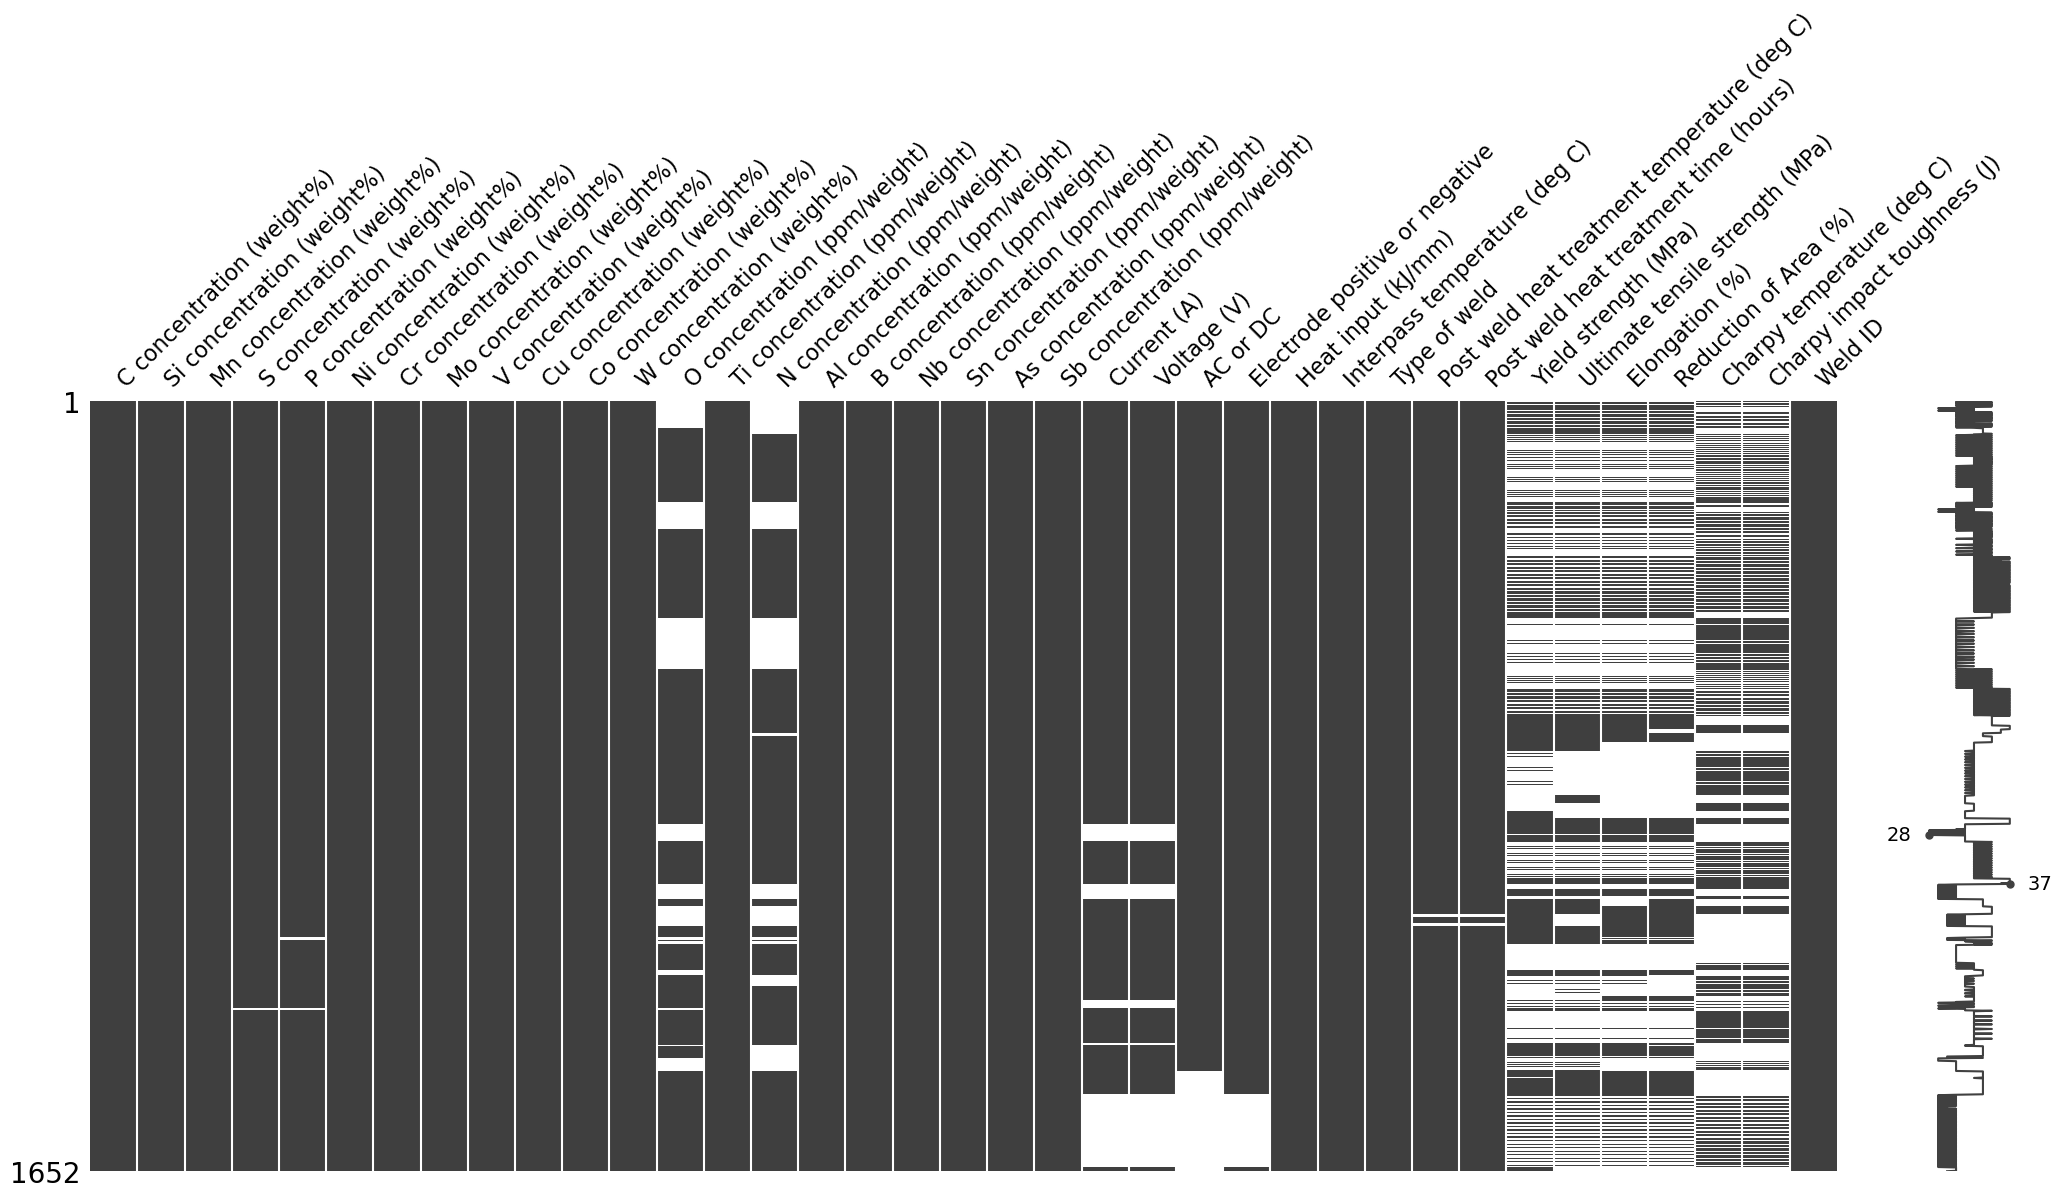

In [36]:
data[data.columns[5:12]]=data[data.columns[5:12]].fillna(0)
data["Ti concentration (ppm/weight)"] = data["Ti concentration (ppm/weight)"].fillna(0)
data[data.columns[15:21]]=data[data.columns[15:21]].fillna(0)

msno.matrix(data)

In [ ]:
data_numeric = data.select_dtypes(include=['Float64'])
string_cols = data.select_dtypes(include=[object])
numeric_cols_z_score_normalized = (data_numeric - data_numeric.mean()) / data_numeric.std()
data_normalized = pd.concat([numeric_cols_z_score_normalized, string_cols], axis=1)

In [37]:
data['AC'] = data['AC or DC'].apply(lambda x: True if x == 'AC' else (False if x == 'DC' else None))
data = data.drop('AC or DC', axis=1)

data['electrode positive'] = data['Electrode positive or negative'].apply(lambda x: False if x == '-' else (True if x == '+' else None))
data = data.drop('Electrode positive or negative', axis=1)
data["electrode positive"] = data["electrode positive"].astype(bool)
data["AC"] = data["AC"].astype(bool)

In [38]:
data = pd.get_dummies(data, columns=['Type of weld'], drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 45 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   C concentration (weight%)                     1652 non-null   float64
 1   Si concentration (weight%)                    1652 non-null   float64
 2   Mn concentration (weight%)                    1652 non-null   float64
 3   S concentration (weight%)                     1648 non-null   float64
 4   P concentration (weight%)                     1642 non-null   float64
 5   Ni concentration (weight%)                    1652 non-null   float64
 6   Cr concentration (weight%)                    1652 non-null   float64
 7   Mo concentration (weight%)                    1652 non-null   float64
 8   V concentration (weight%)                     1652 non-null   float64
 9   Cu concentration (weight%)                    1652 non-null   f

<Axes: >

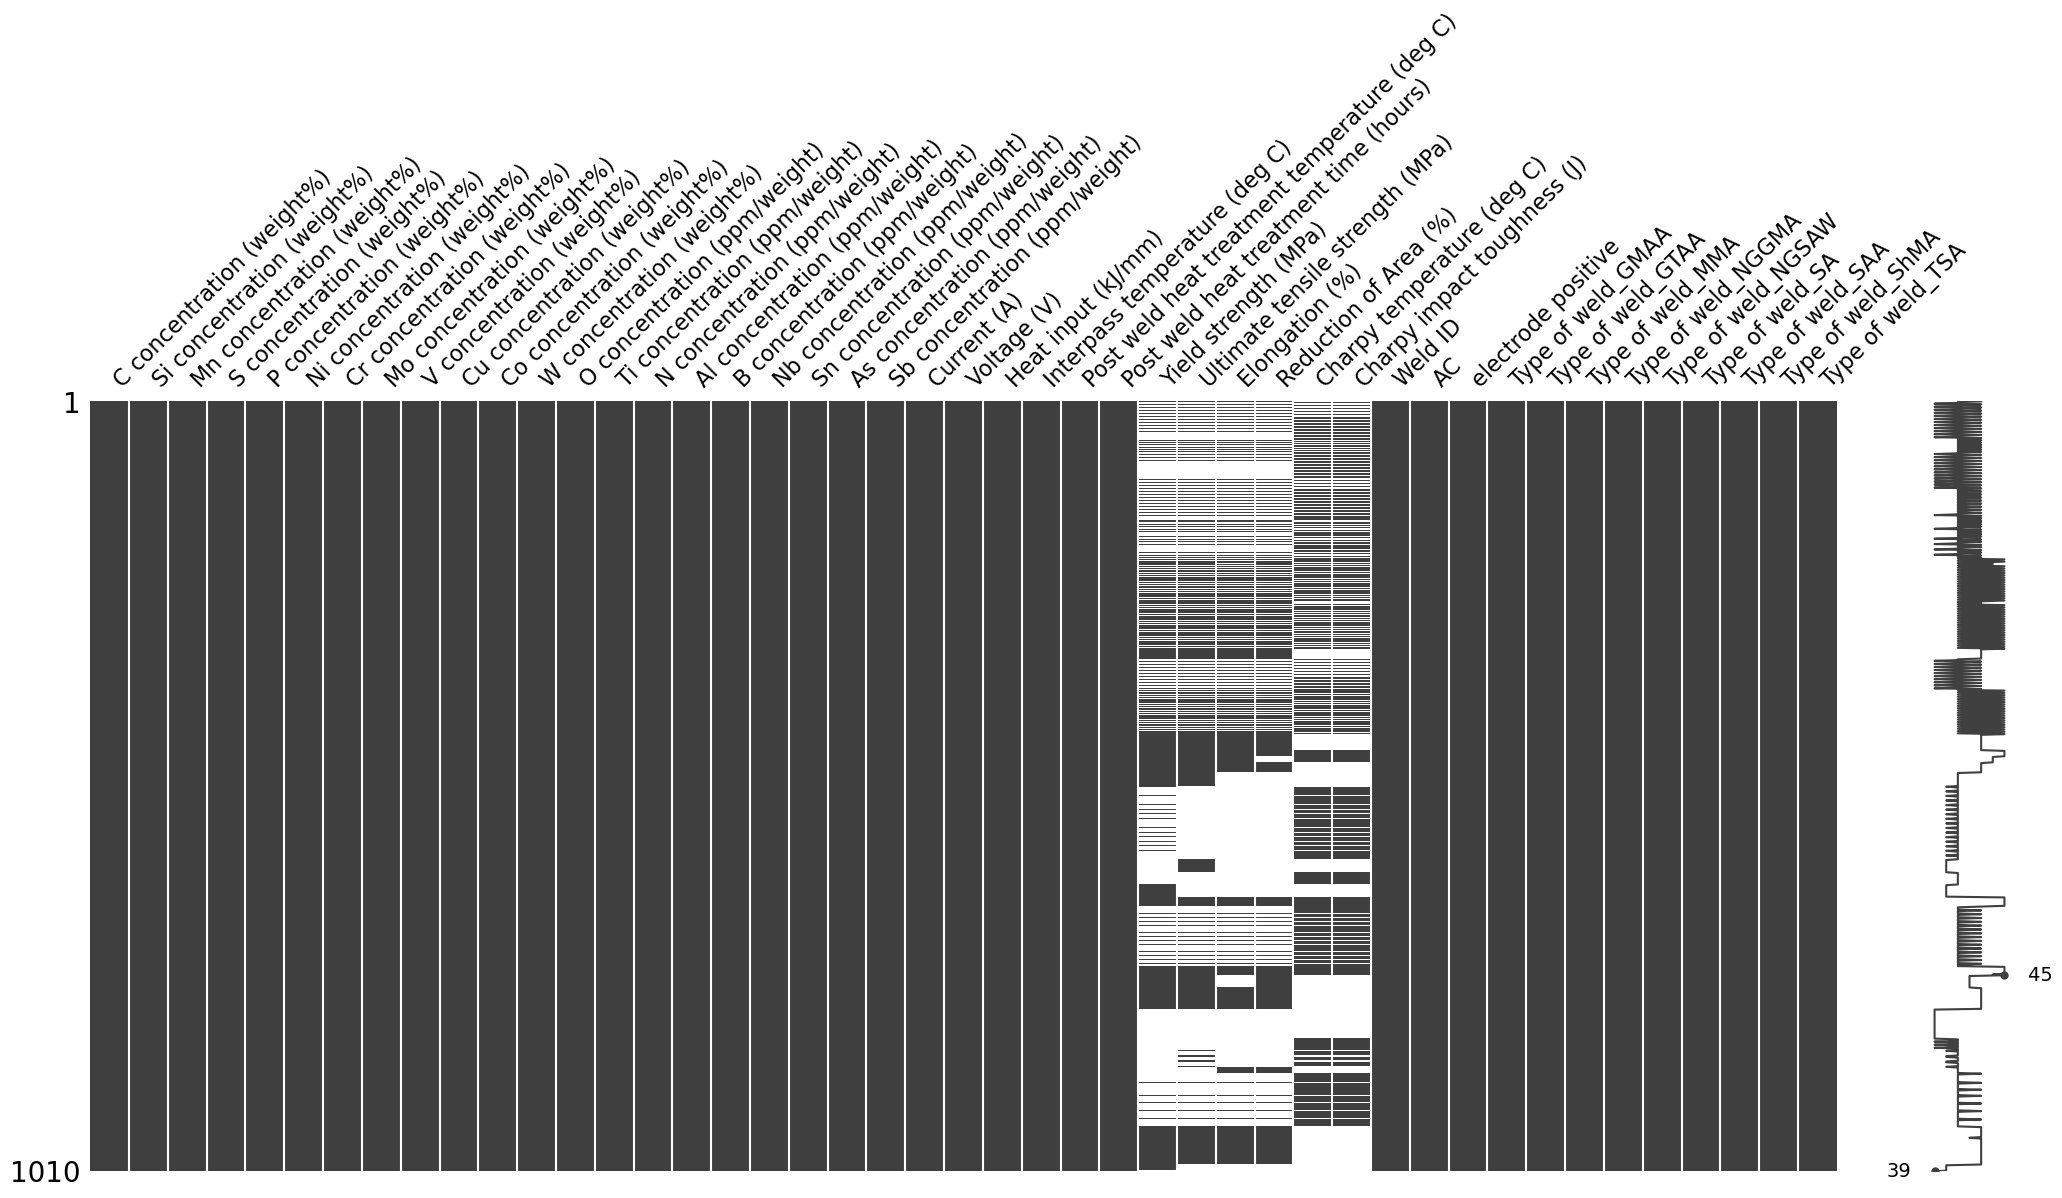

In [39]:
data = data.dropna(axis=0,subset=data.columns[0:27])
msno.matrix(data)

In [30]:
data_numeric = data.select_dtypes(include=['Float64'])
string_cols = data.select_dtypes(include=[object])
numeric_cols_z_score_normalized = (data_numeric - data_numeric.mean()) / data_numeric.std()
data = pd.concat([numeric_cols_z_score_normalized, string_cols], axis=1)


In [40]:
bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)

In [12]:
data.duplicated().sum()

10

In [24]:
data.duplicated(subset=['Weld ID'], keep='first')

70      False
71      False
72      False
73      False
74      False
        ...  
1647    False
1648    False
1649    False
1650    False
1651    False
Length: 1010, dtype: bool

In [41]:
data = data.drop_duplicates(subset='Weld ID', keep='first')

In [42]:
data.drop('Weld ID', axis=1,inplace=True)

In [43]:
data.to_csv('../../data/data_no_reg_no_dup.csv',index=False)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 856 entries, 70 to 1651
Data columns (total 44 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   C concentration (weight%)                     856 non-null    float64
 1   Si concentration (weight%)                    856 non-null    float64
 2   Mn concentration (weight%)                    856 non-null    float64
 3   S concentration (weight%)                     856 non-null    float64
 4   P concentration (weight%)                     856 non-null    float64
 5   Ni concentration (weight%)                    856 non-null    float64
 6   Cr concentration (weight%)                    856 non-null    float64
 7   Mo concentration (weight%)                    856 non-null    float64
 8   V concentration (weight%)                     856 non-null    float64
 9   Cu concentration (weight%)                    856 non-null    float6

In [63]:
from sklearn.preprocessing import StandardScaler
dbscan = DBSCAN(eps=4, min_samples=15)
scaler = StandardScaler()
data['cluster'] = dbscan.fit_predict(scaler.fit_transform(data.dropna(axis=1)))

# Outliers will be labeled as -1

data_no_out = data[data['cluster'] != -1]
data_no_out = data_no_out.drop(['cluster'],axis=1)

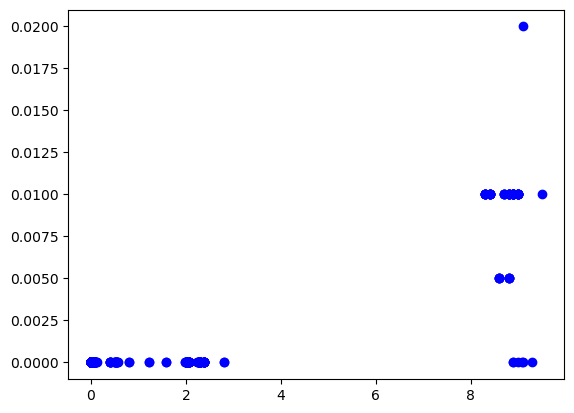

In [71]:
plt.plot(data_no_out['Cr concentration (weight%)'],data_no_out['Co concentration (weight%)'],'ob')

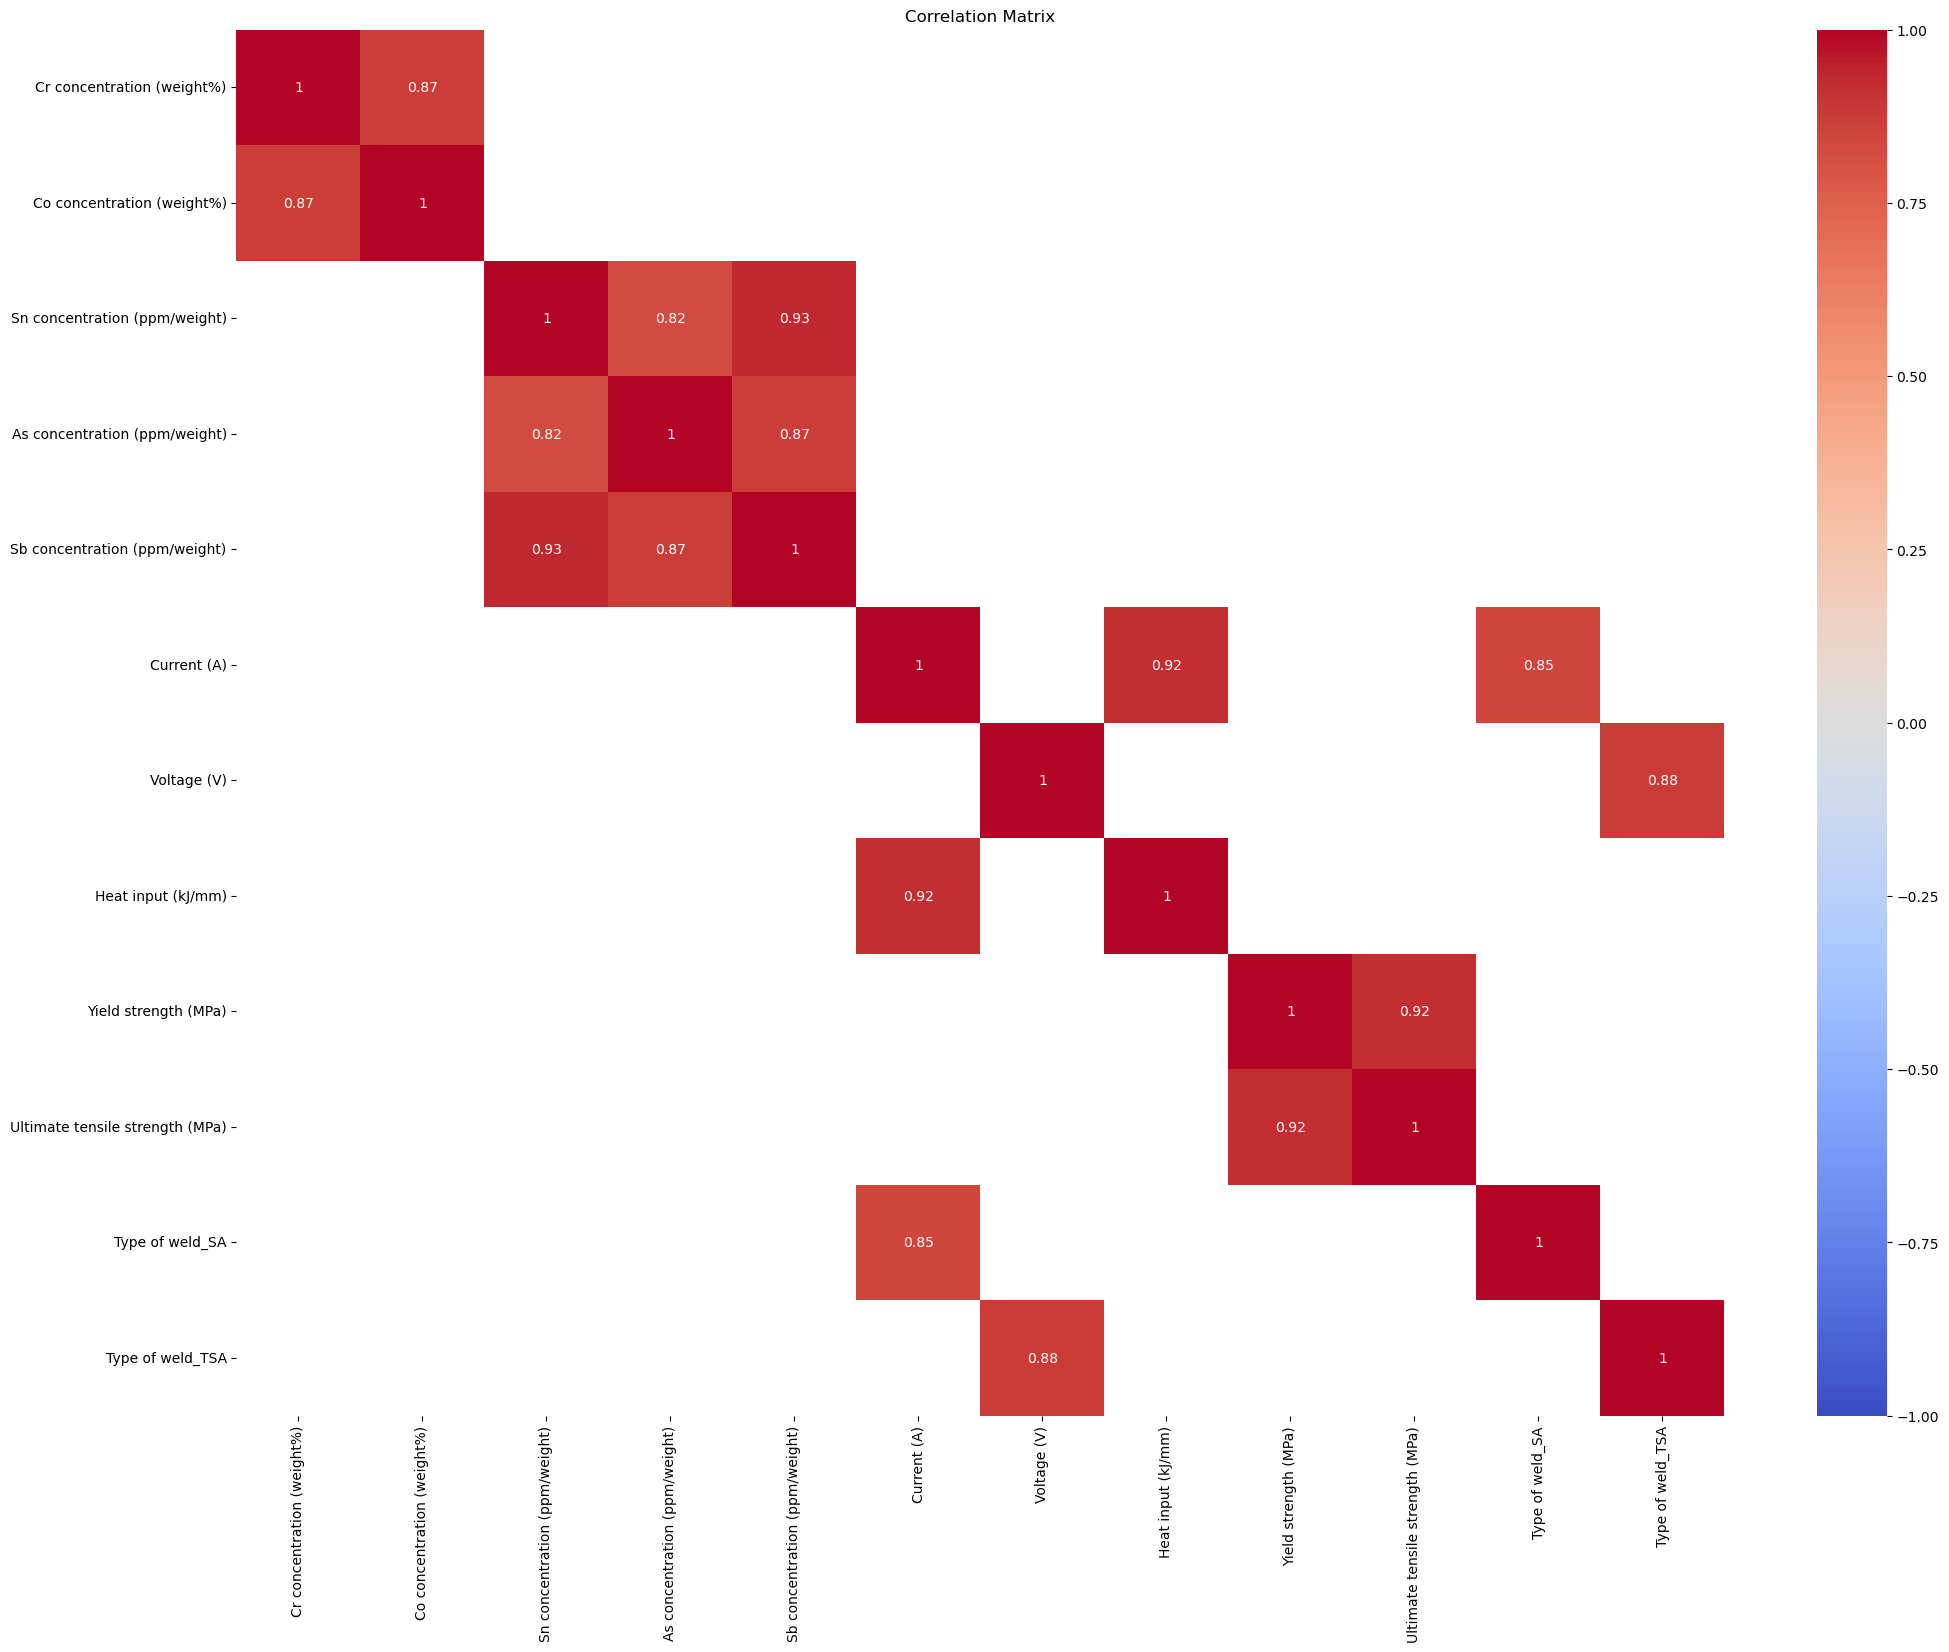

In [67]:
corr_matrix = data_no_out.select_dtypes(include='number').corr()
high_corrs_vars = corr_matrix.columns[((corr_matrix.abs() > 0.8) & (corr_matrix.abs() < 0.99)).any(axis=0)]
filtered_corr_matrix = corr_matrix.loc[high_corrs_vars,high_corrs_vars]
filtered_corr_matrix = filtered_corr_matrix[(filtered_corr_matrix>0.8)|(filtered_corr_matrix<-0.8)]
plt.figure(figsize=(24, 18))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()